In [231]:
# Импорт необходимых библиотек для монтирования диска
import os

#==монтирование google drive в colab и просмотр содержимого dataset
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Data/docs_ds/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Data/docs_ds


**1. Настройка**

***1.1 Импорт и конфигурирование библиотек***

In [232]:
# Библиотеки для обработки данных.
import numpy as np
import scipy as sp
from scipy.spatial import distance
import pandas as pd

# Библиотеки для визуализации данных.
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable


# Библиотеки для моделирования данных.
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils, Input, callbacks
from tensorflow.keras.layers import Conv1D, Dense, Embedding, Flatten, MaxPool1D, Dropout
from tensorflow.keras import regularizers
# Служебные библиотеки.
import re
import math
import time
import shutil


# Определение версий библиотек.
print("Версия NumPy:", np.__version__)
print("Версия Pandas:", pd.__version__)
print("Версия Matplotlib:", matplotlib.__version__)
print("Версия Seaborn:", sns.__version__)
print("Версия Scikit-learn:", sklearn.__version__)
print("Версия TensorFlow:", tf.__version__)

# Настройка NumPy.
# Установка точности до четырёх знаков после запятой.
# Установка `Ширины строки` на значение `Максимум 130 символов в выводе.
# После вывода 130 символов, вывод продолжится на следующей строке.
np.set_printoptions(precision=4, linewidth=130)

# Конфигурация Seaborn.
sns.set_style("whitegrid")  # Установка фона белого цвета и сетки.
sns.set_palette("deep")  # Установка цветовой палитры.
sns.set_context("paper", font_scale=1.25)  # Установка размера шрифта на 1.25 больше обычного.

# Конфигурация Tensorflow.
tf.random.set_seed(100)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

Версия NumPy: 2.0.2
Версия Pandas: 2.2.2
Версия Matplotlib: 3.10.0
Версия Seaborn: 0.13.2
Версия Scikit-learn: 1.6.1
Версия TensorFlow: 2.19.0


In [233]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***1.2 Задание констант и вспомогательных (служебных) функций***

In [234]:
import os
# Константы.
DOCS_CSV = "/content/drive/My Drive/Data/preprocessed/preprocessed.csv"
GLOVE_TXT = "/content/drive/My Drive/Data/glove/glove.6B.100d.txt"

LOGS_DIR = "/content/drive/My Drive/Data/logs"
MODELS_DIR = "/content/drive/My Drive/Data/models"
os.makedirs(MODELS_DIR, exist_ok=True)

MODEL_FILE = os.path.join(MODELS_DIR, "best_model.keras")
TOKENIZER_FILE = os.path.join(MODELS_DIR, "tokenizer.json")
META_FILE = os.path.join(MODELS_DIR, "meta.json")


TYPES_COUNT = 4  # Количество меток типа (класса).
OUTPUT_DIM = 100  # Размерность выходного измерения.

# Предел Epochs для раннего завершения обучения (EarlyStopping).
# Количество эпох без улучшений, после которых обучение будет остановлено.
PATIENCE = 3

# Сопоставление классов и меток
types_map = {'Confidential': 0, 'Internal': 1, 'Public': 2, 'Restricted': 3}

In [235]:
# Вспомогательные (служебные) функции.

#===Функция сжатия строки путем отображения многоточия между
#   первыми n и последними n символами
def func_viewNValues(row_loc, n=5):
    if row_loc is None:
        return "[]"

    left_hand_symbols = []
    right_hand_symbols = []
    for idx, value in enumerate(row_loc):
        if idx < n:
            left_hand_symbols.append(str(value))
        elif idx >= (len(row_loc) - n):
            right_hand_symbols.append(str(value))

    left_hand_symbols = ", ".join(left_hand_symbols)
    delimeters = ", ..." if len(row_loc) > 2 * n else ""
    right_hand_symbols = f", {', '.join(right_hand_symbols)}" if len(right_hand_symbols) else ""

    return f"[{left_hand_symbols + delimeters + right_hand_symbols}]"

# Lambda-функция, уменьшающая входное 'value' на 'percent' процентов.
decreaseBy = lambda value, percent: value - (percent * value / 100)


#===Функция вычисления косинусного сходства между двумя входными словами
#   на основе их GloVe-векторов
def func_cosineSimilarity(glove_vectors_index_loc, word_1_loc, word_2_loc):

    vector_1 = glove_vectors_index_loc.get(word_1_loc.lower())
    print(f"Вектор GloVe для `{word_1_loc}`: {func_viewNValues(vector_1, 3)}")

    vector_2 = glove_vectors_index_loc.get(word_2_loc.lower())
    print(f"Вектор GloVe для `{word_2_loc}`: {func_viewNValues(vector_2, 3)}")

    cosine_distance = distance.cosine(vector_1, vector_2)
    print(f"Косинусное сходство между '{word_1_loc}' и '{word_2_loc}': {round(cosine_distance, 4)}")


***1.3 Сброс содержимого каталогов***

In [236]:
# Удаление журналов и сохраненных моделей.
shutil.rmtree(LOGS_DIR, ignore_errors=True)
shutil.rmtree(MODELS_DIR, ignore_errors=True)


***1.4 Загрузка набора данных***

In [237]:
documents_dataframe = pd.read_csv(DOCS_CSV)
documents_dataframe.head(3)

,ID,Размер текста,Текст,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,...,PROPN,PUNCT,SCONJ,VERB,X,SYM,Тип,Размер,Путь,Категория
0,C_240,2959,memorandum department head senior management d...,29.0,44.0,10.0,18.0,15.0,34.0,2.0,...,49,79,2.0,45.0,20.0,0.0,Confidential,3073,/content/drive/My Drive/Data/docs_ds/confident...,0
1,C_242,2253,human_resources_department employee onboarding...,13.0,23.0,2.0,8.0,6.0,11.0,3.0,...,104,126,3.0,26.0,48.0,0.0,Confidential,2378,/content/drive/My Drive/Data/docs_ds/confident...,0
2,C_234,2883,memo change employee vacation policy departmen...,34.0,61.0,5.0,26.0,14.0,34.0,3.0,...,37,62,4.0,44.0,5.0,0.0,Confidential,2980,/content/drive/My Drive/Data/docs_ds/confident...,0


In [238]:
import numpy as np

types_map_4 = types_map.copy()
inv_types_map_4 = {v: k for k, v in types_map_4.items()}


cat = documents_dataframe["Категория"]

if np.issubdtype(cat.dtype, np.number):
    cat_names = cat.map(inv_types_map_4)
else:
    cat_names = cat.astype(str)

BINARY_MAP = {
    "Confidential": 1,
    "Restricted": 1,
    "Internal": 0,
    "Public": 0,
}

documents_dataframe["Категория2"] = cat_names.map(BINARY_MAP).astype("int32")

documents_dataframe["Категория"] = documents_dataframe["Категория2"]

types_map = {"NonSensitive": 0, "Sensitive": 1}
TYPES_COUNT = 2

print("Binary counts:", documents_dataframe["Категория"].value_counts().sort_index().to_dict())


Binary counts: {0: 596, 1: 612}


**2. EDA (анализ данных)**

In [239]:
rows, columns = documents_dataframe.shape
print(f"Набор данных содержит {rows} строк и {columns} столбцов.\n")

documents_dataframe.info()


Набор данных содержит 1208 строк и 25 столбцов.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             1208 non-null   object 
 1   Размер текста  1208 non-null   int64  
 2   Текст          1208 non-null   object 
 3   ADJ            1208 non-null   float64
 4   ADP            1208 non-null   float64
 5   ADV            1208 non-null   float64
 6   AUX            1208 non-null   float64
 7   CCONJ          1208 non-null   float64
 8   DET            1208 non-null   float64
 9   INTJ           1208 non-null   float64
 10  NOUN           1208 non-null   float64
 11  NUM            1208 non-null   float64
 12  PART           1208 non-null   float64
 13  PRON           1208 non-null   float64
 14  PROPN          1208 non-null   int64  
 15  PUNCT          1208 non-null   int64  
 16  SCONJ          1208 non-null   float64
 17  VER

**3. Служебные операции**

***3.1 Токенизация***

In [240]:
documents_tokenizer = Tokenizer(
    num_words=5000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',  # Удаление символа подчеркивания.
    oov_token="<UNK>",  # Токен, отсутствующий в словаре.
)

documents_tokenizer.fit_on_texts(documents_dataframe["Текст"].values)
import json

import os
from pathlib import Path

# 1) Явно фиксируем путь и создаём папку прямо здесь
MODELS_DIR = "/content/drive/MyDrive/Data/models"
Path(MODELS_DIR).mkdir(parents=True, exist_ok=True)

TOKENIZER_FILE = os.path.join(MODELS_DIR, "tokenizer.json")

# 2) Диагностика (очень важно увидеть перед open)
print("MODELS_DIR:", repr(MODELS_DIR))
print("exists:", os.path.exists(MODELS_DIR), "isdir:", os.path.isdir(MODELS_DIR))
print("TOKENIZER_FILE:", repr(TOKENIZER_FILE))
print("parent exists:", os.path.exists(os.path.dirname(TOKENIZER_FILE)))

# 3) Сохранение
with open(TOKENIZER_FILE, "w", encoding="utf-8") as f:
    f.write(documents_tokenizer.to_json())

print("Saved tokenizer:", TOKENIZER_FILE)


MODELS_DIR: '/content/drive/MyDrive/Data/models'
exists: True isdir: True
TOKENIZER_FILE: '/content/drive/MyDrive/Data/models/tokenizer.json'
parent exists: True
Saved tokenizer: /content/drive/MyDrive/Data/models/tokenizer.json


In [241]:
# Индексация слов.
word_index = documents_tokenizer.word_index
vocabulary_size = len(word_index)  # Размер словаря.

print("Общее количество слов в словаре:", vocabulary_size)
print("\nПример индексации слов:")
{k: v for k, v in list(word_index.items())[:10]}

Общее количество слов в словаре: 14587

Пример индексации слов:


{'<UNK>': 1,
 'company': 2,
 '1': 3,
 'information': 4,
 'document': 5,
 'product': 6,
 '2': 7,
 '2023': 8,
 'sale': 9,
 'date': 10}

In [242]:
# Кодированиетекста документов в последовательности.
encoding_documents = documents_tokenizer.texts_to_sequences(documents_dataframe["Текст"].values)

print("Последовательности:")
print("Тип данных:", type(encoding_documents))
print("Общее количество:", len(encoding_documents))
print("Примеры значений:")
_ = [print(func_viewNValues(row_curr)) for row_curr in encoding_documents[:3]]

Последовательности:
Тип данных: <class 'list'>
Общее количество: 1208
Примеры значений:
[104, 44, 270, 362, 95, ..., 843, 255, 2297, 78, 5]
[2935, 11, 2204, 3396, 351, ..., 244, 10, 68, 244, 10]
[486, 158, 11, 805, 28, ..., 11, 805, 28, 5, 35]


In [243]:
sequence_lengths = [len(x) for x in encoding_documents]

# Получение максимальной длины обучающей последовательности.
maximum_length = max(sequence_lengths)
print("Размер самой длинной последовательности:", maximum_length)

# Получение минимальной длины обучающей последовательности.
minimum_length = min(sequence_lengths)
print("Размер самой короткой последовательности:", minimum_length)

Размер самой длинной последовательности: 419
Размер самой короткой последовательности: 12


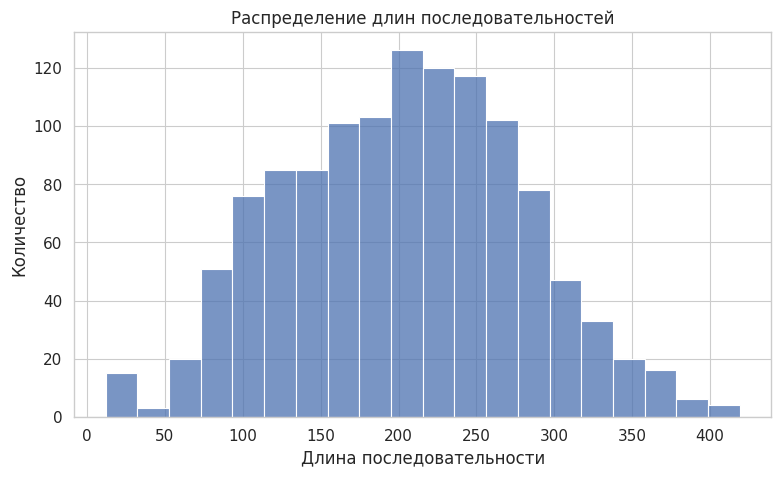

In [244]:
# Определение наилучшего значения длины последовательности.
plt.figure(figsize=(9, 5))

sns.histplot(x=sequence_lengths)
plt.xlabel("Длина последовательности")
plt.ylabel("Количество")
plt.title("Распределение длин последовательностей")

plt.show()

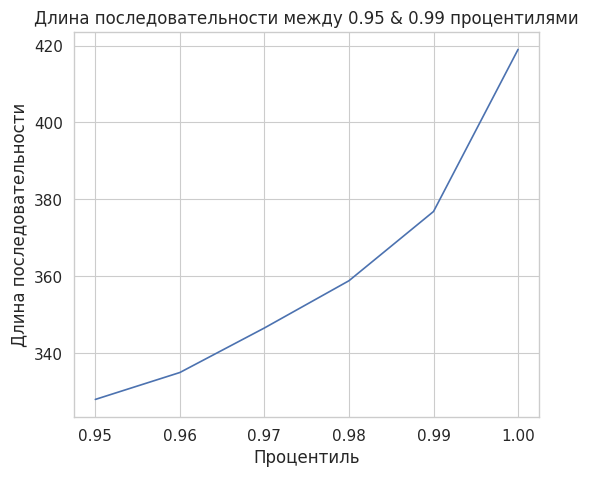

In [245]:
# Выбор длины последовательности в соответствии с методом Elbow
low_level, high_level = 0.95, 1
plt.figure(figsize=(6, 5))

x = np.arange(low_level, high_level, 0.01)
y = np.quantile(a=np.array(sequence_lengths), q=x)

sns.lineplot(x=x, y=y)
plt.title(f"Длина последовательности между {low_level} & {round(high_level - 0.01, 2)} процентилями")
plt.xlabel("Процентиль")
plt.ylabel("Длина последовательности")

plt.show()

In [246]:
# ~99% документов имеют длину последовательности менее 380, поэтому выбирается это значение для sequence_length.
sequence_length = 380

***3.2 Дополнение (Padding)***

In [247]:
padding_documents = pad_sequences(encoding_documents, maxlen=sequence_length, padding="post", truncating="post")

print("Дополненные последовательности:")
print("Тип данных:", type(padding_documents), "Размерность:", padding_documents.shape)
print("Примеры значений:")
print(padding_documents)

Дополненные последовательности:
Тип данных: <class 'numpy.ndarray'> Размерность: (1208, 380)
Примеры значений:
[[ 104   44  270 ...    0    0    0]
 [2935   11 2204 ...    0    0    0]
 [ 486  158   11 ...    0    0    0]
 ...
 [  46  676   10 ...    0    0    0]
 [1137 1252  934 ...    0    0    0]
 [  58  272 1510 ...    0    0    0]]


In [248]:
import numpy as np

# 1) сколько пустых текстов
texts = documents_dataframe["Текст"].astype(str).values
empty_frac = np.mean([len(t.strip()) == 0 for t in texts])
print("EMPTY TEXT FRACTION:", empty_frac)

# 2) насколько много OOV (<UNK>) после токенизации
seq = documents_tokenizer.texts_to_sequences(texts)
lens = np.array([len(s) for s in seq])
print("AVG SEQ LEN:", lens.mean(), "MED:", np.median(lens), "ZERO LEN:", np.mean(lens == 0))

# OOV token index обычно 1 (т.к. oov_token="<UNK>")
oov_idx = 1
total_tokens = sum(len(s) for s in seq)
oov_tokens = sum(sum(1 for x in s if x == oov_idx) for s in seq)
print("OOV RATE:", (oov_tokens / total_tokens) if total_tokens > 0 else None)


EMPTY TEXT FRACTION: 0.0
AVG SEQ LEN: 203.375 MED: 206.0 ZERO LEN: 0.0
OOV RATE: 0.0560329212746818


***3.3 Векторы GloVe***

In [249]:
%%time

# Загрузка векторов слов.
# Загрузка полного набора.
glove_vectors_index = dict()
with open(GLOVE_TXT, encoding="utf8") as glove_text_file:
    for line in glove_text_file.readlines():
        columns = line.split()
        word_current = columns[0]
        vec = np.array(columns[1:], dtype="float32")
        glove_vectors_index[word_current] = vec

CPU times: user 12.4 s, sys: 548 ms, total: 12.9 s
Wall time: 13.2 s


In [250]:
print("Общее количество слов в GloVe:", len(glove_vectors_index.keys()))
print("Примеры векторов слов:")

result_table = PrettyTable(["Слово", "Предварительно обученный вектор"], align="l")
result_table.add_rows([[k, func_viewNValues(v, n=3)] for k, v in list(glove_vectors_index.items())[:5]])

print(result_table)

Общее количество слов в GloVe: 400000
Примеры векторов слов:
+-------+-----------------------------------------------------------------+
| Слово | Предварительно обученный вектор                                 |
+-------+-----------------------------------------------------------------+
| the   | [-0.038194, -0.24487, 0.72812, ..., -0.1459, 0.8278, 0.27062]   |
| ,     | [-0.10767, 0.11053, 0.59812, ..., -0.83155, 0.45293, 0.082577]  |
| .     | [-0.33979, 0.20941, 0.46348, ..., -0.23394, 0.47298, -0.028803] |
| of    | [-0.1529, -0.24279, 0.89837, ..., -0.591, 1.0039, 0.20664]      |
| to    | [-0.1897, 0.050024, 0.19084, ..., -0.39804, 0.47647, -0.15983]  |
+-------+-----------------------------------------------------------------+


In [251]:
# Пропущенные слова.
missing_words = [word_current for word_current in word_index.keys() if word_current not in glove_vectors_index.keys()]
missing_words_count = len(missing_words)
missing_words_percent = round(missing_words_count / len(word_index.keys()) * 100, 1)
print(f"{missing_words_count} то есть, {missing_words_percent}% слов в словаре не имеют векторов GloVe.")

6794 то есть, 46.6% слов в словаре не имеют векторов GloVe.


In [252]:
# Загрузка весов.

# Все нулевые векторы.
zero_vectors = np.zeros(OUTPUT_DIM)

weights = [zero_vectors]  # Для <PAD>

# Создание матрицы весов для слов в словаре.
for word_current in word_index.keys():
    weights.append(glove_vectors_index.get(word_current, zero_vectors).tolist())


weights = tf.convert_to_tensor(weights, dtype=tf.float32)
print("Тип данных весов:", weights.dtype)
print("Размерность весов:", weights.shape)

Тип данных весов: <dtype: 'float32'>
Размерность весов: (14588, 100)


In [253]:
import numpy as np

# какие индексы реально встречаются в твоих данных (в padding_documents)
used_ids = np.unique(padding_documents)
used_ids = used_ids[used_ids != 0]  # 0 это padding

# считаем, сколько из реально используемых токенов имеют НЕ нулевой embedding
nonzero_rows = np.any(weights != 0, axis=1)

covered = nonzero_rows[used_ids].mean() if len(used_ids) else 0.0
print("USED UNIQUE TOKENS:", len(used_ids))
print("EMBEDDING COVERAGE AMONG USED TOKENS:", covered)

# доп. полезно: сколько нулевых строк в целом (для понимания)
print("NONZERO ROWS FRACTION (overall):", nonzero_rows.mean())


USED UNIQUE TOKENS: 4999
EMBEDDING COVERAGE AMONG USED TOKENS: 0.7941588317663533
NONZERO ROWS FRACTION (overall): 0.5342061968741432


***3.4 Косинусное подобие***

In [254]:
# Пример 1
func_cosineSimilarity(glove_vectors_index, "Color", "Colour")

Вектор GloVe для `Color`: [-0.52516, 0.44118, -0.1273, ..., -0.88581, 0.075446, 0.040447]
Вектор GloVe для `Colour`: [-0.87662, 0.21689, -0.32172, ..., -0.53163, 0.0032544, -0.19457]
Косинусное сходство между 'Color' и 'Colour': 0.1234000027179718


In [255]:
func_cosineSimilarity(glove_vectors_index, "Juice", "Table")

Вектор GloVe для `Juice`: [-0.51079, 0.30394, -0.42261, ..., -0.16562, 0.4512, 0.58224]
Вектор GloVe для `Table`: [-0.61454, 0.89693, 0.56771, ..., 0.2179, 1.4143, 0.40034]
Косинусное сходство между 'Juice' и 'Table': 0.723800003528595


***3.5 Функции POS***

In [256]:
# Количество частей речи в документе.
# Этот признак целесообразно включить вместе с дополненными последовательностями
# в качестве входных данных для сети.

documents_dataframe.iloc[:, 3:18].astype("int32").head()

,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,VERB
0,29,44,10,18,15,34,2,115,1,17,12,49,79,2,45
1,13,23,2,8,6,11,3,69,2,6,6,104,126,3,26
2,34,61,5,26,14,34,3,118,20,7,14,37,62,4,44
3,19,34,7,14,11,23,5,67,4,9,10,31,37,4,35
4,34,72,5,20,16,53,2,152,13,11,15,50,75,2,68


**4. Настройка пользовательских Callbacks**

***4.1 Callback #1: Показатели производительности***¶

In [257]:
# Callback для вычисления и печати оценки F1 для набора проверочных данных.
class ProductivityIndicators(callbacks.Callback):
    def __init__(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test

    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Остановка распространения Callbacks.
            return

        cl_probability = self.model.predict(self.X_test)
        y_prediction = np.argmax(cl_probability, axis=1)

        f1_scr = f1_score(self.y_test, y_prediction, average="micro")
        print("F1-score для проверочного набора данных:", round(f1_scr, 4))

***4.2 Callback #2. SaveBetterModel***

In [258]:
# Callback для сохранения модели в каждой эпохе, если точность проверки
# улучшается по сравнению с предыдущей эпохой.

class SaveBetterModel(callbacks.ModelCheckpoint):
    def __init__(self, **kwargs):
        super().__init__(
            monitor="val_accuracy",
            verbose=2,
            save_best_only=True,
            mode="max",
            **kwargs,
        )

    def on_epoch_end(self, epoch, logs=None):
        # Для остановки распространения Callbacks.
        if self.model.stop_training:
            return

        super().on_epoch_end(epoch, logs)

***4.3 Callback #3. TerminateWhenNaN***

In [259]:
class TerminateWhenNaN(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Остановка распространения Callbacks.
            return

        # Проверка уровня потерь для значений NaN.
        loss = logs.get("loss")
        if (loss is not None) and (np.isnan(loss) or np.isinf(loss)):
            print("Недействительная потеря. Жпоха прекращена:", epoch)
            # Сообщить следующему Callback о пропуске выполнения
            self.model.stop_training = True
            return

***4.4 Callback #4. DecayLearningRate***

In [260]:
# Уменьшение скорости обучения на 10%, если точность проверки текущей эпохи ниже точности предыдущей эпохи.
# Уменьшение скорости обучения на 5% каждую третью эпоху.

class DecayLearningRate(callbacks.Callback):
    def __init__(self):
        self.prev_val_acc = 0  # previous validation accuracy.

    def __get_lr__(self):
        return float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))

    def __set_lr__(self, new_lr):
        # tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)
        new_lr = np.asarray(new_lr, dtype=x.dtype)
        self.model.optimizer.learning_rate.assign(new_lr)

    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Stop propagation of callbacks.
            return

        curr_val_acc = logs.get("val_accuracy")
        lr = self.__get_lr__()
        if curr_val_acc < self.prev_val_acc:
            new_lr = decreaseBy(lr, 10)
            self.__set_lr__(new_lr)
            print("Current epoch validation accuracy:", round(curr_val_acc, 4))
            print("Previous epoch validation accuracy:", round(self.prev_val_acc, 4))
            print("Reducing learning rate by 10%. New learning rate:", round(new_lr, 6))
        elif not (epoch + 1) % 3:
            # Since epochs start at zero, add one to get current epoch number.
            new_lr = decreaseBy(lr, 5)
            self.__set_lr__(new_lr)
            print("Reducing learning rate by 5%. New learning rate:", round(new_lr, 6))

        # Save current validation accuracy value for next epoch.
        self.prev_val_acc = curr_val_acc

***4.5 Callback #5. TerminayeOnNoChange***

In [261]:
# Ранняя остановка: обучение прекращается, когда точность проверки перестает улучшаться.

class TerminateOnNoChange(callbacks.EarlyStopping):
    def __init__(self, epochs):
        super().__init__(monitor="val_accuracy", patience=epochs, verbose=2, mode="max")

    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Остановка распространения Callbacks.
            return

        super().on_epoch_end(epoch, logs)

**5. Настройка обучения**

***5.1 Разделение выборки на обучающую, тестовую и валидационную (проверочную)***

In [262]:
# 1) Текстовые токены (N, 380)
X_text = padding_documents.astype("int32")

# 2) POS-фичи: берём все колонки, которые выглядят как POS-теги (UPPERCASE),
# исключая служебные
POS_COLS = [c for c in documents_dataframe.columns if c.isupper() and c not in {"ID"}]
POS_COLS = sorted(POS_COLS)  # фиксируем порядок

X_pos = documents_dataframe[POS_COLS].fillna(0).astype("float32").to_numpy()

# длина документа в токенах (по X_text)
doc_len = (X_text != 0).sum(axis=1).astype("float32").reshape(-1, 1)

# превращаем POS-счётчики в "доли" и сглаживаем
X_pos = X_pos / np.maximum(doc_len, 1.0)
X_pos = np.log1p(X_pos)

# Целевой столбец
y = documents_dataframe["Категория"].astype("int32")

print("X_text:", X_text.shape, X_text.dtype)
print("X_pos :", X_pos.shape, X_pos.dtype)
print("y     :", y.shape, y.dtype)
print("POS_COLS:", POS_COLS)

meta = {
    "sequence_length": int(sequence_length),
    "pos_cols": POS_COLS,
    "types_map": types_map,
}
with open(f"{MODELS_DIR}/meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print("Saved meta:", f"{MODELS_DIR}/meta.json")

# --- Split: одновременно делим X_text, X_pos и y ---
X_text_train, X_text_test, X_pos_train, X_pos_test, y_train, y_test = train_test_split(
    X_text, X_pos, y,
    test_size=0.25,
    stratify=y,
    random_state=42,
)

X_text_train, X_text_cval, X_pos_train, X_pos_cval, y_train, y_cval = train_test_split(
    X_text_train, X_pos_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42,
)

y_train = y_train.to_numpy(dtype="float32").reshape(-1, 1)
y_cval  = y_cval.to_numpy(dtype="float32").reshape(-1, 1)
y_test  = y_test.to_numpy(dtype="float32").reshape(-1, 1)
print(type(y_train), y_train.shape, y_train.dtype, y_train[:5].T)
print("model output:", work_model.output_shape)



pos_norm = tf.keras.layers.Normalization(name="pos_norm")
pos_norm.adapt(X_pos_train.astype("float32"))


print("Train:", X_text_train.shape, X_pos_train.shape, y_train.shape)
print("CVal :", X_text_cval.shape, X_pos_cval.shape, y_cval.shape)
print("Test :", X_text_test.shape, X_pos_test.shape, y_test.shape)


X_text: (1208, 380) int32
X_pos : (1208, 17) float32
y     : (1208,) int32
POS_COLS: ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']
Saved meta: /content/drive/MyDrive/Data/models/meta.json
<class 'numpy.ndarray'> (724, 1) float32 [[1. 1. 1. 0. 0.]]
model output: (None, 1)
Train: (724, 380) (724, 17) (724, 1)
CVal : (182, 380) (182, 17) (182, 1)
Test : (302, 380) (302, 17) (302, 1)


**6. Работа с моделью (моделирование)**

In [263]:
# Сброс всех состояний, сгенерированных Keras.
tf.keras.backend.clear_session()

***6.1 Определение архитектуры модели***

In [264]:
# двухвходовая модель

text_len = X_text_train.shape[1]     # должно быть 380
pos_dim  = X_pos_train.shape[1]      # сколько POS-колонок получилось

text_input = Input(shape=(text_len,), dtype="int32", name="Input_Text")
pos_input  = Input(shape=(pos_dim,),  dtype="float32", name="Input_POS")

# Embedding только для текста!
x = Embedding(
    vocabulary_size + 1,
    OUTPUT_DIM,
    input_length=text_len,
    name="EmbeddingLayer1",
    weights=[weights],
    trainable=False,
)(text_input)

# Текстовая ветка — оставляем твою CNN-логику
f1 = Conv1D(4, 3, padding="same", activation="relu", name="Conv1D_F1_Filters")(x)
f2 = Conv1D(8, 3, padding="same", activation="relu", name="Conv1D_F2_Filters")(x)
f3 = Conv1D(16, 3, padding="same", activation="relu", name="Conv1D_F3_Filters")(x)
f1f2f3 = tf.keras.layers.concatenate([f1, f2, f3], name="Concatenate1_F1F2F3")
t = MaxPool1D(3, name="MaxPoolLayer1")(f1f2f3)

f4 = Conv1D(2, 3, padding="same", activation="relu", name="Conv1D_F4_Filters")(t)
f5 = Conv1D(4, 3, padding="same", activation="relu", name="Conv1D_F5_Filters")(t)
f6 = Conv1D(8, 3, padding="same", activation="relu", name="Conv1D_F6_Filters")(t)
f4f5f6 = tf.keras.layers.concatenate([f4, f5, f6], name="Concatenate2_F4F5F6")
t = MaxPool1D(3, name="MaxPoolLayer2")(f4f5f6)

t = Conv1D(8, 3, padding="same", activation="relu", name="Conv1D_P_Filters")(t)
t = tf.keras.layers.GlobalMaxPooling1D()(t)
t = Dropout(0.25, name="DropOut_Text")(t)
t = Dense(30, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(t)


# POS-ветка (числа напрямую в Dense!)
p = pos_norm(pos_input)
p = Dense(16, activation="relu", name="Dense_POS")(p)
p = Dropout(0.2, name="DropOut_POS")(p)

# Объединяем
h = tf.keras.layers.concatenate([t, p], name="Concat_Text_POS")
h = Dropout(0.25, name="DropOut_Concat")(h)
h = Dense(30, activation="relu", name="Dense_Concat")(h)

outputs = Dense(1, activation="sigmoid", name="Output")(h)
work_model = tf.keras.Model(inputs=[text_input, pos_input], outputs=outputs, name="Documents_Classification")

work_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "Documents_Classification"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Text          │ (None, 380)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EmbeddingLayer1     │ (None, 380, 100)  │  1,458,800 │ Input_Text[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_F1_Filters   │ (None, 380, 4)    │      1,204 │ EmbeddingLayer1[… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_F2_Filters   │ (None, 380, 8)    │      2,408 │ EmbeddingLayer1[… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_F3_Filters   │ (None, 380, 16)   │      4,816 │ EmbeddingLayer1[… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenate1_F1F2F3 │ (None, 380, 28)   │          0 │ Conv1D_F1_Filter… │
│ (Concatenate)       │                   │            │ Conv1D_F2_Filter… │
│                     │                   │            │ Conv1D_F3_Filter… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPoolLayer1       │ (None, 126, 28)   │          0 │ Concatenate1_F1F… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_F4_Filters   │ (None, 126, 2)    │        170 │ MaxPoolLayer1[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_F5_Filters   │ (None, 126, 4)    │        340 │ MaxPoolLayer1[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_F6_Filters   │ (None, 126, 8)    │        680 │ MaxPoolLayer1[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenate2_F4F5F6 │ (None, 126, 14)   │          0 │ Conv1D_F4_Filter… │
│ (Concatenate)       │                   │            │ Conv1D_F5_Filter… │
│                     │                   │            │ Conv1D_F6_Filter… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPoolLayer2       │ (None, 42, 14)    │          0 │ Concatenate2_F4F… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_P_Filters    │ (None, 42, 8)     │        344 │ MaxPoolLayer2[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_POS           │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 8)         │          0 │ Conv1D_P_Filters… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pos_norm            │ (None, 17)        │         35 │ Input_POS[0][0]   │
│ (Normalization)     │                   │            │                 

 Total params: 1,470,796 (5.61 MB)

 Trainable params: 11,961 (46.72 KB)

 Non-trainable params: 1,458,835 (5.57 MB)

***6.2 Отображение архитектуры модели***

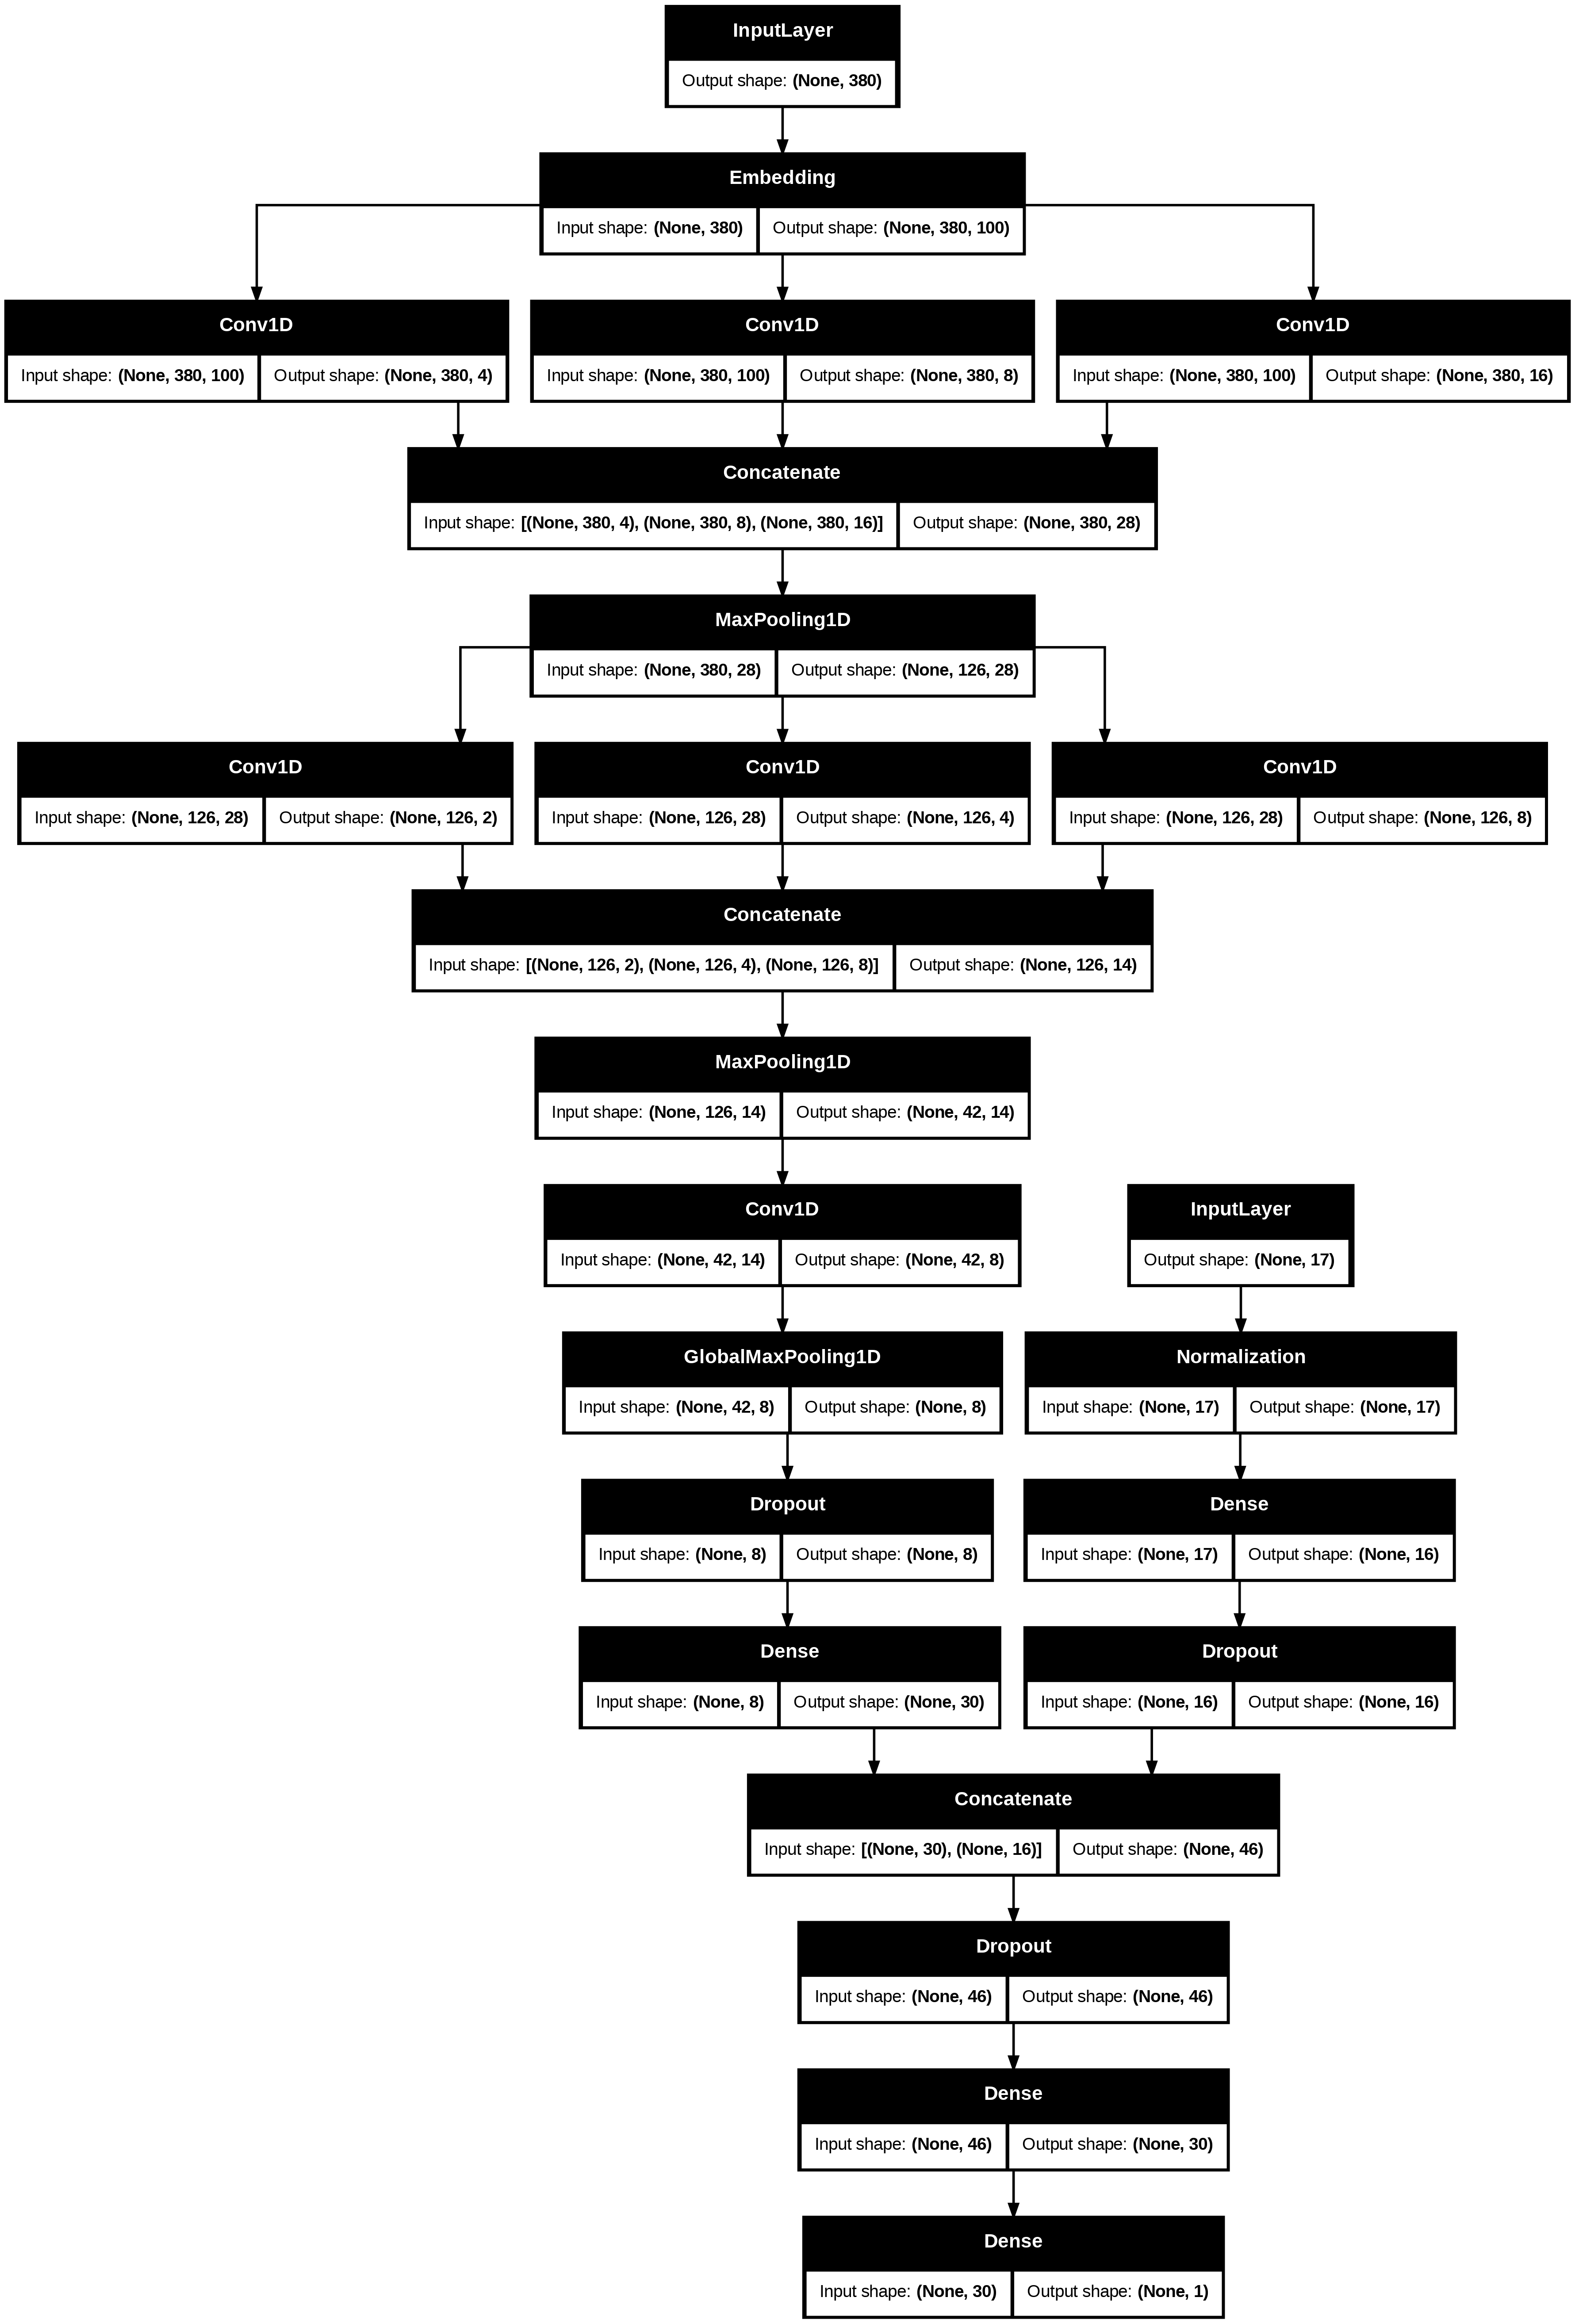

In [265]:
utils.plot_model(work_model, "Documents_Classification_Model.png", show_shapes=True)

***6.3 Компиляция модели***

In [266]:
opt = tf.keras.optimizers.Adam(1e-3, clipnorm=1.0)

work_model.compile(
    optimizer=opt,
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="prec"),
        tf.keras.metrics.Recall(name="rec"),
    ],
)

***6.4 Обучение модели***

In [267]:
# Обработка несбалансированного набора данных
import numpy as np
y_train_1d = y_train.reshape(-1).astype(int)
classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_1d)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, cw)}
print("class_weight:", class_weight_dict)

class_weight: {0: 1.0140056022408963, 1: 0.9863760217983651}


In [268]:
# --- DEBUG: имена и формы входов модели (работает в новых Keras) ---
print("MODEL INPUT TENSORS:")
for t in work_model.inputs:
    print("  tensor:", t.name, "shape:", t.shape, "dtype:", t.dtype)

input_keys = [t.name.split(":")[0] for t in work_model.inputs]  # убираем ":0"
print("INPUT KEYS (for dict):", input_keys)

print("X_text_train:", X_text_train.shape, X_text_train.dtype, "max:", X_text_train.max())
print("X_pos_train :", X_pos_train.shape, X_pos_train.dtype, "min/max:", X_pos_train.min(), X_pos_train.max())


MODEL INPUT TENSORS:
  tensor: Input_Text shape: (None, 380) dtype: int32
  tensor: Input_POS shape: (None, 17) dtype: float32
INPUT KEYS (for dict): ['Input_Text', 'Input_POS']
X_text_train: (724, 380) int32 max: 4999
X_pos_train : (724, 17) float32 min/max: 0.0 0.67372906


In [269]:
# --- Обучение ---
train_history = work_model.fit(
    x={
        "Input_Text": X_text_train,
        "Input_POS":  X_pos_train.astype("float32"),
    },
    y=y_train,
    batch_size=64,
    epochs=30,
    verbose=2,
    class_weight=class_weight_dict,
    callbacks=[
tf.keras.callbacks.ModelCheckpoint(MODEL_FILE, monitor="val_loss", save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),

    ],
    validation_data=(
        {"Input_Text": X_text_cval, "Input_POS": X_pos_cval.astype("float32")},
        y_cval
    ),
)


Epoch 1/30

Epoch 1: val_loss improved from inf to 0.71258, saving model to /content/drive/My Drive/Data/models/best_model.keras
12/12 - 9s - 732ms/step - accuracy: 0.5221 - auc: 0.5172 - loss: 0.7175 - prec: 0.5301 - rec: 0.5041 - val_accuracy: 0.5000 - val_auc: 0.4679 - val_loss: 0.7126 - val_prec: 0.5079 - val_rec: 0.3478 - learning_rate: 1.0000e-03
Epoch 2/30

Epoch 2: val_loss improved from 0.71258 to 0.70645, saving model to /content/drive/My Drive/Data/models/best_model.keras
12/12 - 1s - 117ms/step - accuracy: 0.5235 - auc: 0.5199 - loss: 0.7147 - prec: 0.5297 - rec: 0.5341 - val_accuracy: 0.5220 - val_auc: 0.4950 - val_loss: 0.7065 - val_prec: 0.5373 - val_rec: 0.3913 - learning_rate: 1.0000e-03
Epoch 3/30

Epoch 3: val_loss improved from 0.70645 to 0.70416, saving model to /content/drive/My Drive/Data/models/best_model.keras
12/12 - 1s - 115ms/step - accuracy: 0.5235 - auc: 0.5591 - loss: 0.6932 - prec: 0.5289 - rec: 0.5477 - val_accuracy: 0.5275 - val_auc: 0.5009 - val_loss:

***6.5 Статистика обучения модели***

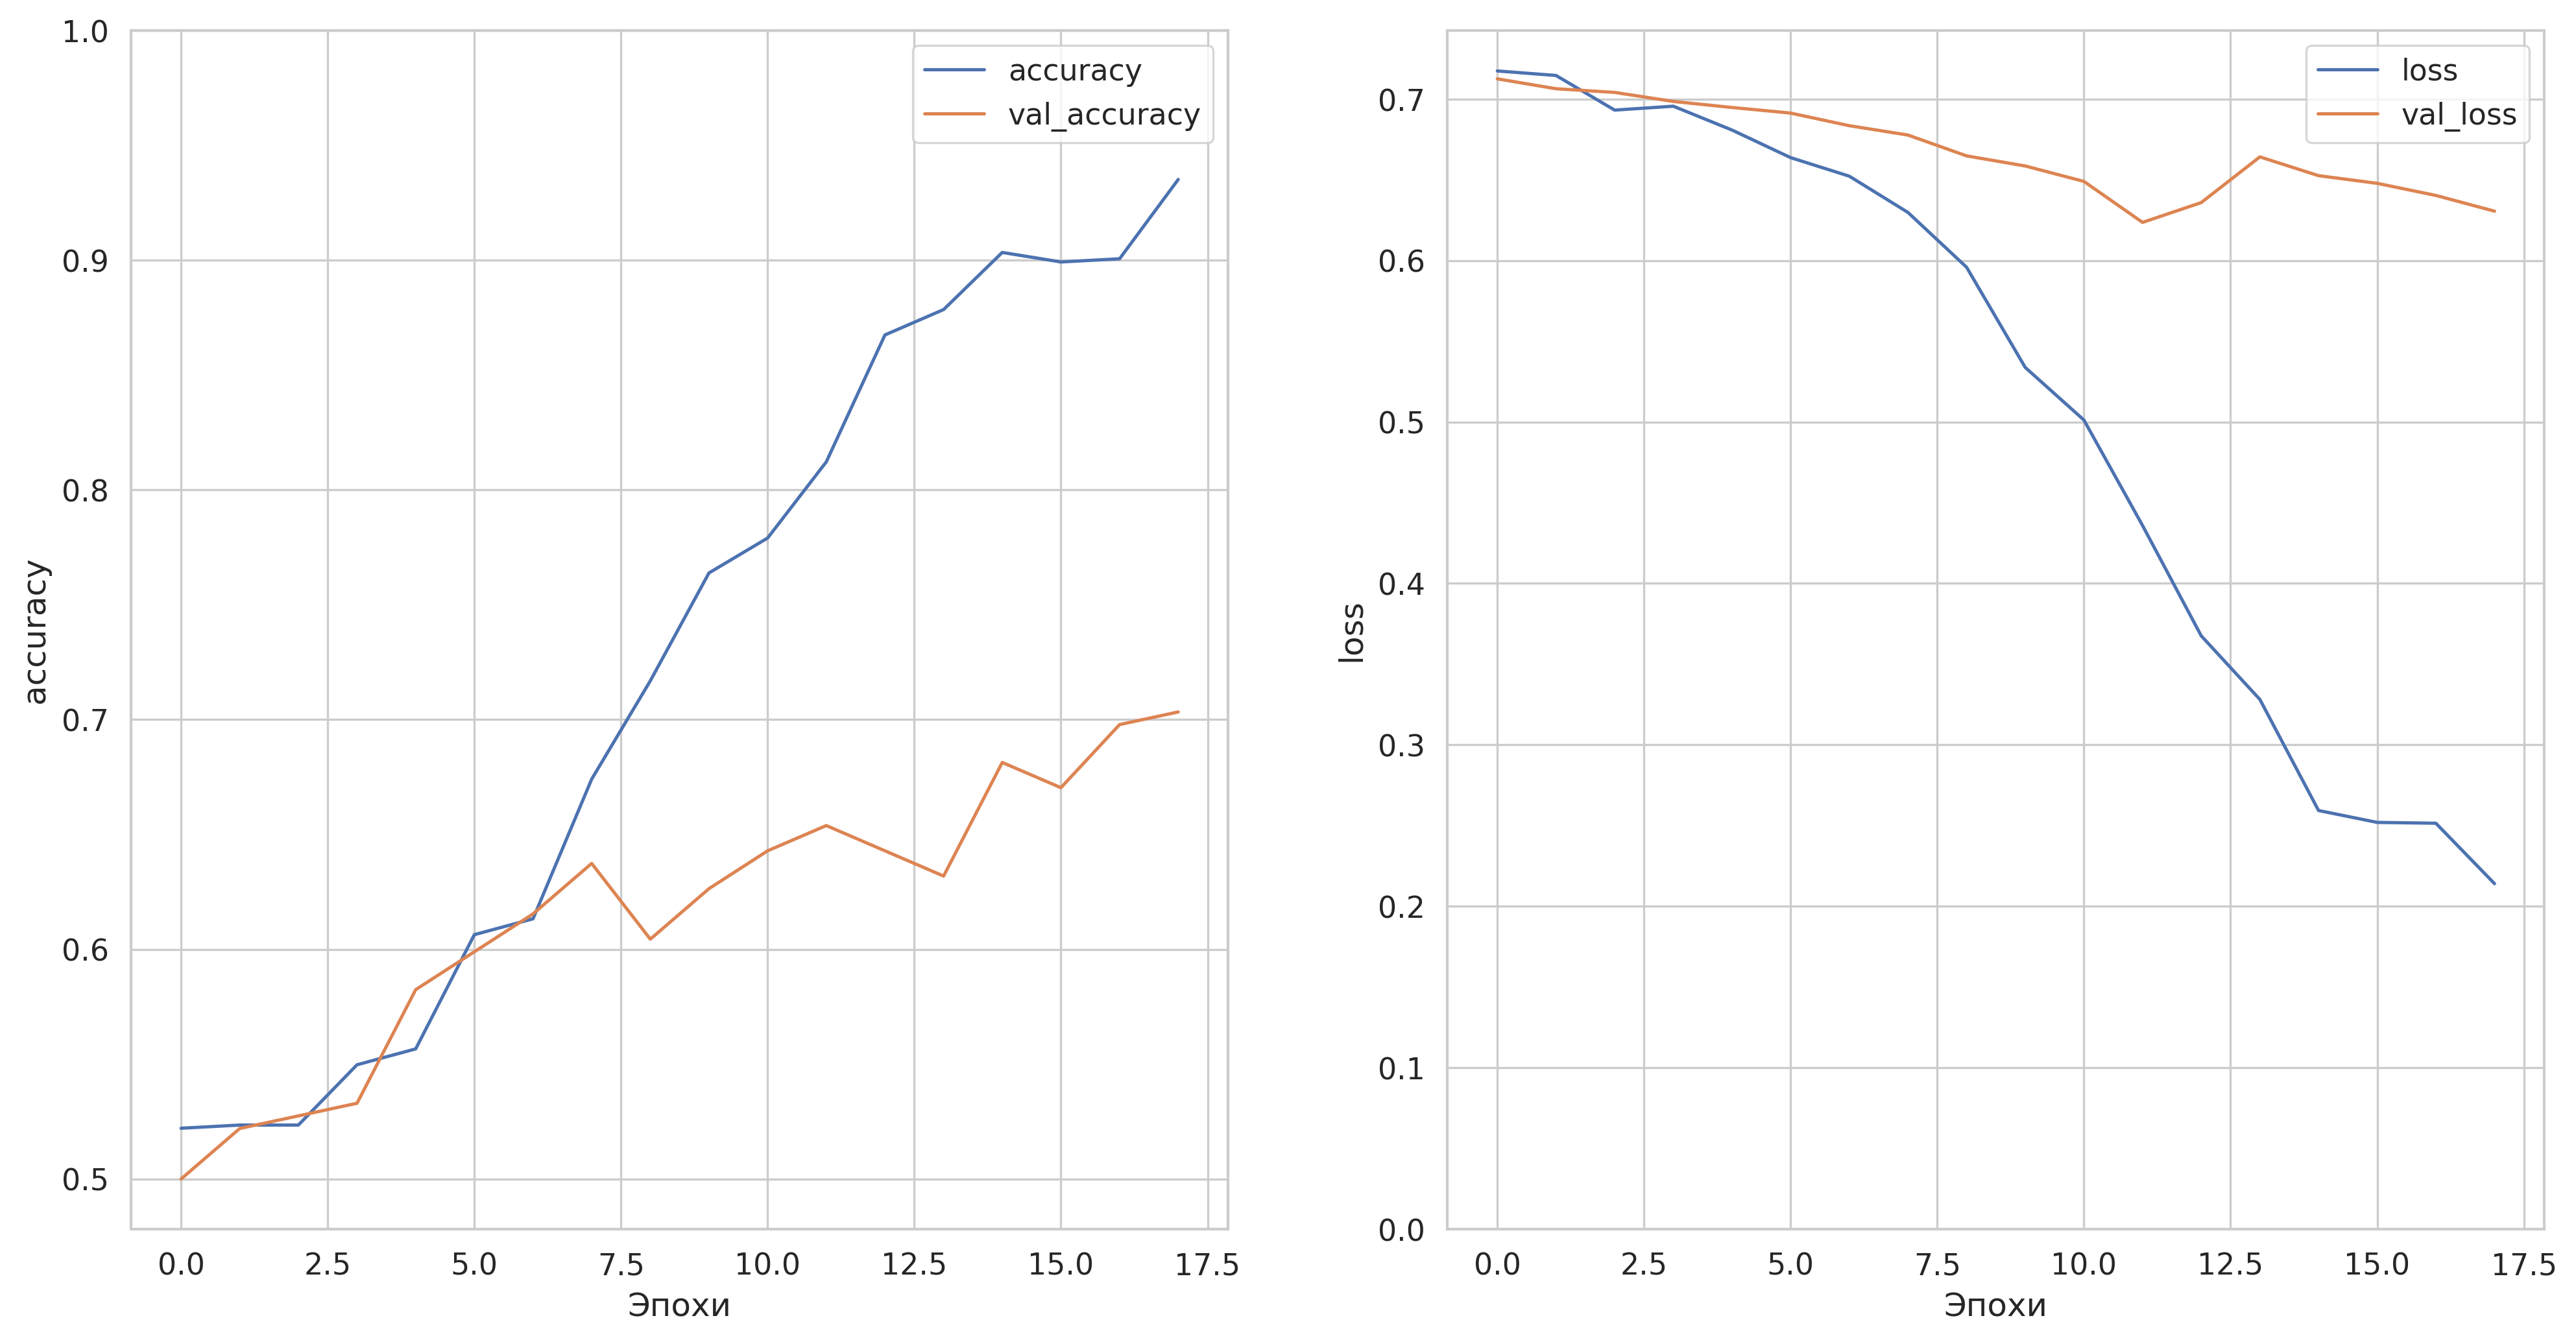

In [270]:
#===Функция отрисовки графиков обучения модели
def func_drawGraphics(history_loc, metric_loc):
    plt.plot(history_loc.history[metric_loc])
    plt.plot(history_loc.history['val_'+metric_loc], '')
    plt.xlabel("Эпохи")
    plt.ylabel(metric_loc)
    plt.legend([metric_loc, 'val_'+metric_loc])

plt.figure(figsize=(16, 8), dpi=300)
plt.subplot(1, 2, 1)
func_drawGraphics(train_history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
func_drawGraphics(train_history, 'loss')
plt.ylim(0, None)

plt.show()

***6.6 Проверка модели***

In [271]:
work_model.evaluate(
    {"Input_Text": X_text_test, "Input_POS": X_pos_test.astype("float32")},
    y_test,
    verbose=2
)


10/10 - 0s - 21ms/step - accuracy: 0.6523 - auc: 0.7291 - loss: 0.6119 - prec: 0.6967 - rec: 0.5556


[0.6118730306625366,
 0.6523178815841675,
 0.7291090488433838,
 0.6967213153839111,
 0.5555555820465088]

**7. Показатели производительности**

***7.1 Матрица путаницы***

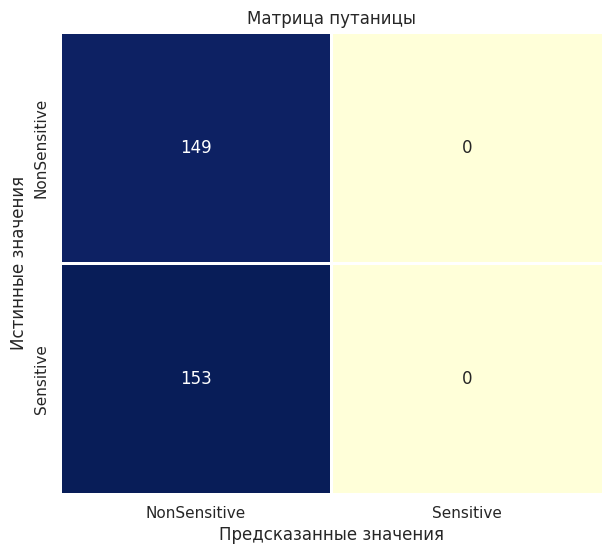

In [272]:
# Предсказание меток класса y_test
types_probability = work_model.predict(
    {"Input_Text": X_text_test, "Input_POS": X_pos_test.astype("float32")},
    verbose=0
)
y_pred = np.argmax(types_probability, axis=1)

# Вычисление матрицы путаницы
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred, TYPES_COUNT).numpy()
labels = [k for k, v in sorted(types_map.items(), key=lambda x: x[1])]  # по индексу 0..3

# Вывод матрицы путаницы
plt.figure(figsize=(7, 6))
sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    cbar=False,
    linecolor="white",
    linewidths=1,
    yticklabels=labels,
    xticklabels=labels,
)
plt.title("Матрица путаницы")
plt.xlabel("Предсказанные значения")
plt.ylabel("Истинные значения")

plt.show()

In [273]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_text(text: str, pos_dict: dict):

    seq = documents_tokenizer.texts_to_sequences([text])
    X_text_new = pad_sequences(
        seq,
        maxlen=sequence_length,
        padding="post",
        truncating="post"
    ).astype("int32")


    X_pos_new = np.array([[float(pos_dict.get(c, 0.0)) for c in POS_COLS]], dtype="float32")


    proba = work_model.predict([X_text_new, X_pos_new], verbose=0)[0]
    cls_id = int(np.argmax(proba))
    return cls_id, proba

cls_id, proba = predict_text(
    "This is a sample document text to classify.",
    {"NOUN": 5, "VERB": 2, "PUNCT": 1}
)
print("class id:", cls_id)
print("proba:", proba)


class id: 0
proba: [0.54]


In [274]:
from sklearn.metrics import f1_score

pred = np.argmax(work_model.predict([X_text_cval, X_pos_cval], verbose=0), axis=1)
print("macro F1:", f1_score(y_cval, pred, average="macro"))


macro F1: 0.33088235294117646


In [275]:
import numpy as np

y_train_1d = np.asarray(y_train).reshape(-1).astype(int)  # (N,) int

counts = np.bincount(y_train_1d)
print("train counts:", counts, "majority acc:", counts.max() / counts.sum())

y_cval_1d  = np.asarray(y_cval ).reshape(-1).astype(int)
counts_v = np.bincount(y_cval_1d)
print("val counts  :", counts_v, "majority acc:", counts_v.max()/counts_v.sum())


train counts: [357 367] majority acc: 0.5069060773480663
val counts  : [90 92] majority acc: 0.5054945054945055
